In [1]:
import pandas as pd

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
df1 = pd.read_parquet('C:/Users/86138/Tigercut/midterm/details.parquet')

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3100 entries, 0 to 3099
Data columns (total 27 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   区县       3099 non-null   float64
 1   名称       3100 non-null   object 
 2   城市       3100 non-null   int64  
 3   板块       3095 non-null   float64
 4   环线位置     1802 non-null   object 
 5   小区地址     3100 non-null   object 
 6   物业类别     3100 non-null   object 
 7   建筑年代     2912 non-null   object 
 8   开发商      2576 non-null   object 
 9   房屋总数     3100 non-null   object 
 10  楼栋总数     3100 non-null   object 
 11  物业公司     2445 non-null   object 
 12  绿 化 率    2714 non-null   object 
 13  容 积 率    2717 non-null   float64
 14  物 业 费    2744 non-null   object 
 15  建筑结构     2957 non-null   object 
 16  物业办公电话   977 non-null    object 
 17  产权描述     3098 non-null   object 
 18  供水       2913 non-null   object 
 19  供暖       2366 non-null   object 
 20  供电       2930 non-null   object 
 21  燃气费      2668 

In [5]:
df1['建筑年代'].value_counts()

建筑年代
2004年         46
2002年         41
2003年         41
2000年         41
1998年         39
              ..
1981-1992年     1
1976-2001年     1
1994-1997年     1
1988-1993年     1
1985-1994年     1
Name: count, Length: 725, dtype: int64

In [6]:
import pandas as pd
import re
from datetime import datetime

def process_construction_year(text):
    # 提取所有四位数年份
    years = list(map(int, re.findall(r'\d{4}', str(text))))
    
    if not years:
        return pd.NaT
    
    # 计算代表性年份
    if len(years) == 1:
        rep_year = years[0]
    else:
        # 对年份范围取中位数（四舍五入）
        sorted_years = sorted(years)
        median = (sorted_years[0] + sorted_years[-1]) / 2
        rep_year = int(round(median))
    
    # 转换为datetime（默认1月1日）
    try:
        return datetime(year=rep_year, month=1, day=1)
    except:
        return pd.NaT

# 应用处理函数
df1['建筑年份'] = df1['建筑年代'].apply(process_construction_year)

# 验证转换结果
print(df1[['建筑年代', '建筑年份']].sample(5))

            建筑年代       建筑年份
2035  1998-2005年 2002-01-01
389   2012-2018年 2015-01-01
1120  2006-2008年 2007-01-01
2925       2003年 2003-01-01
245   2008-2010年 2009-01-01


In [7]:
df2 = pd.read_parquet('C:/Users/86138/Tigercut/midterm/rent.parquet')

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84150 entries, 0 to 84149
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   城市      84150 non-null  int64  
 1   小区名称    84150 non-null  object 
 2   户型      84149 non-null  object 
 3   装修      29916 non-null  object 
 4   价格      84150 non-null  int64  
 5   楼层      84145 non-null  object 
 6   面积      84150 non-null  object 
 7   朝向      84145 non-null  object 
 8   交易时间    84150 non-null  object 
 9   付款方式    69127 non-null  object 
 10  租赁方式    84150 non-null  object 
 11  电梯      84148 non-null  object 
 12  车位      21377 non-null  object 
 13  用水      72771 non-null  object 
 14  用电      73206 non-null  object 
 15  燃气      81965 non-null  object 
 16  采暖      61414 non-null  object 
 17  租期      44315 non-null  object 
 18  配套设施    58921 non-null  object 
 19  lon     84150 non-null  float64
 20  lat     84150 non-null  float64
 21  年份      84150 non-null  float64
dty

In [9]:
df2['面积'] = df2['面积'].str.extract(r'(\d+\.?\d*)\s*㎡').astype(float)
df2['平均租价'] = df2['价格'] / df2['面积']

In [10]:
df = pd.read_parquet('C:/Users/86138/Tigercut/midterm/train_cleaned.parquet')

In [11]:
coords_df = df[['lon', 'lat']].values
coords_df1 = df1[['coord_x', 'coord_y']].values
coords_df2 = df2[['lon', 'lat']].values

In [12]:
from sklearn.neighbors import NearestNeighbors

# 匹配 df1 的 "建筑年份"
nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(coords_df1)
distances, indices = nn.kneighbors(coords_df)
df['建筑年份'] = df1.iloc[indices.flatten()]['建筑年份'].values

# 匹配 df2 的 "平均租价"
nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(coords_df2)
distances, indices = nn.kneighbors(coords_df)
df['平均租价'] = df2.iloc[indices.flatten()]['平均租价'].values

In [13]:
import pandas as pd
import numpy as np

# 计算每个小区的平均建筑年份（忽略缺失值）
小区平均年份 = df.groupby('小区名称')['建筑年份'].transform(lambda x: x.mean(skipna=True))

# 计算每个板块的平均建筑年份（忽略缺失值）
板块平均年份 = df.groupby('板块')['建筑年份'].transform(lambda x: x.mean(skipna=True))

In [14]:
# 优先用小区平均值填充
df['建筑年份'] = df['建筑年份'].fillna(小区平均年份)

# 若小区平均值仍为NaN（说明该小区完全缺失建筑年份），则用板块平均值填充
df['建筑年份'] = df['建筑年份'].fillna(板块平均年份)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83291 entries, 0 to 83290
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   城市                       83291 non-null  int64         
 1   区域                       83291 non-null  float64       
 2   板块                       83291 non-null  float64       
 3   环线                       83291 non-null  category      
 4   小区名称                     83291 non-null  object        
 5   价格                       83291 non-null  int64         
 6   建筑结构                     83291 non-null  category      
 7   装修情况                     83291 non-null  category      
 8   别墅类型                     83291 non-null  category      
 9   交易时间                     83291 non-null  datetime64[ns]
 10  交易权属                     83291 non-null  category      
 11  房屋用途                     83291 non-null  category      
 12  房屋年限                     83291 n

In [16]:
df = df.dropna(subset=['建筑年份'])

In [17]:
# 提取年份并计算年龄
df['建筑年龄'] = df['交易时间'].dt.year - df['建筑年份'].dt.year

原始数据量: 3100
过滤后数据量: 82363
异常值数量: 832


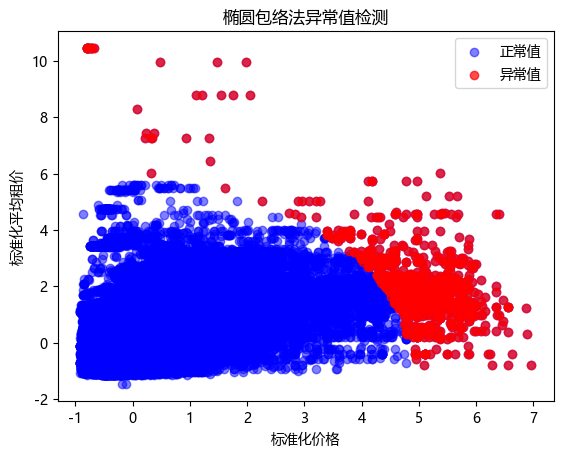

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler

# 提取目标特征
X = df[['价格', '平均租价']].values

# 标准化数据（椭圆包络对尺度敏感）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 拟合椭圆包络模型
# contamination参数：预期异常值比例（根据数据调整）
envelope = EllipticEnvelope(contamination=0.01, random_state=111)  
envelope.fit(X_scaled)

# 预测异常值（-1表示异常，1表示正常）
outliers = envelope.predict(X_scaled) == -1
df_clean = df[~outliers]

# 输出结果
print(f"原始数据量: {len(df1)}")
print(f"过滤后数据量: {len(df_clean)}")
print(f"异常值数量: {outliers.sum()}")

# 可视化异常值
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c='blue', label='正常值', alpha=0.5)
plt.scatter(X_scaled[outliers, 0], X_scaled[outliers, 1], c='red', label='异常值', alpha=0.7)
plt.xlabel('标准化价格')
plt.ylabel('标准化平均租价')
plt.title('椭圆包络法异常值检测')
plt.legend()
plt.show()

In [20]:
columns_to_keep = [
'城市', '区域', '板块', '环线', '小区名称', '价格', '建筑结构', '装修情况', '别墅类型',
'交易时间', '交易权属', '房屋用途', '房屋年限', '产权所属', 'lon', 'lat', '年份',
'室', '厅', '厨', '卫', '相对楼层', '总楼层', '使用面积', 'has_东', 'has_南',
'has_西', 'has_北', 'has_东南', 'has_东北', 'has_西南', 'has_西北', '户数',
'elevators_per_household', '距上次交易', '优势_装修', '优势_地铁', '优势_满五',
'优势_满二', '商业配套', '教育配套', '医疗配套', '生态配套', '金融配套', '地铁线路数',
'公交线路数', '主干道数', '交通枢纽', '平均租价', '建筑年龄'
]

cleaned_df = df_clean[columns_to_keep]

In [21]:
cleaned_df.to_parquet(
    path='C:/Users/86138/Tigercut/midterm/train_plus.parquet',  # 文件路径
    engine='pyarrow',               # 推荐引擎（支持更全的数据类型）
    compression='snappy',           # 压缩方式（可选：'snappy', 'gzip', 'brotli' 等）
    index=False                      # 不保存索引
)

In [22]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82363 entries, 0 to 83290
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   城市                       82363 non-null  int64         
 1   区域                       82363 non-null  float64       
 2   板块                       82363 non-null  float64       
 3   环线                       82363 non-null  category      
 4   小区名称                     82363 non-null  object        
 5   价格                       82363 non-null  int64         
 6   建筑结构                     82363 non-null  category      
 7   装修情况                     82363 non-null  category      
 8   别墅类型                     82363 non-null  category      
 9   交易时间                     82363 non-null  datetime64[ns]
 10  交易权属                     82363 non-null  category      
 11  房屋用途                     82363 non-null  category      
 12  房屋年限                     82363 non-nu